Import packages

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objs as go

Load data

In [230]:
train_data = pd.read_csv("data/train.csv")

test_data = pd.read_csv("data/test.csv")

In [231]:
# Check data
train_data = train_data.fillna(np.nan)
train_data.info()

missing_values_count = train_data.isnull().sum()
print(missing_values_count)

total_cells = np.product(train_data.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print("Percent of missing values: ", percent_missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0       PassengerId  891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Sex              891 non-null    object 
 5   Age              714 non-null    float64
 6   SibSp            891 non-null    int64  
 7   Parch            891 non-null    int64  
 8   Ticket           891 non-null    object 
 9   Fare             891 non-null    float64
 10  Cabin            204 non-null    object 
 11  Embarked         889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
    PassengerId      0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                177
SibSp                0
Parch                0
Tick

Summarize data

In [232]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Feature analysis

Numerical variables

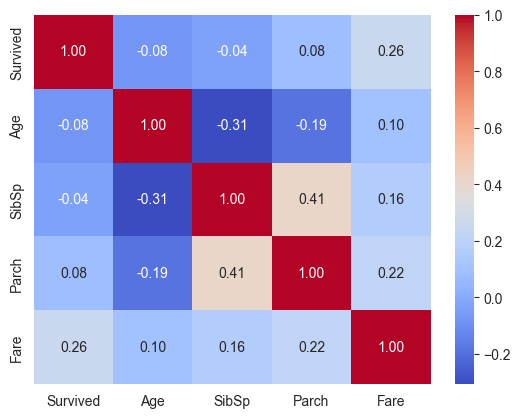

In [233]:
g = sns.heatmap(train_data[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, fmt=".2f", cmap="coolwarm")

SibSP

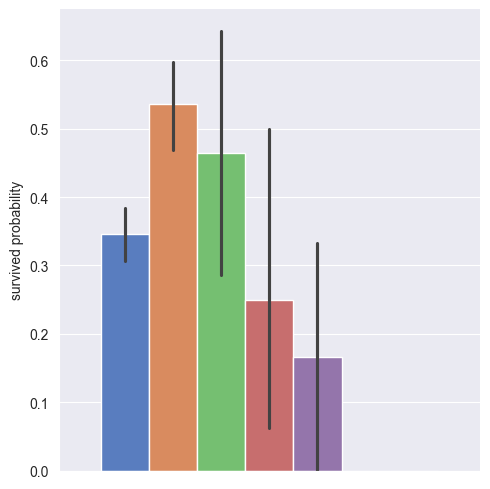

In [234]:
g = sns.catplot(hue="SibSp", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("survived probability")

Parch

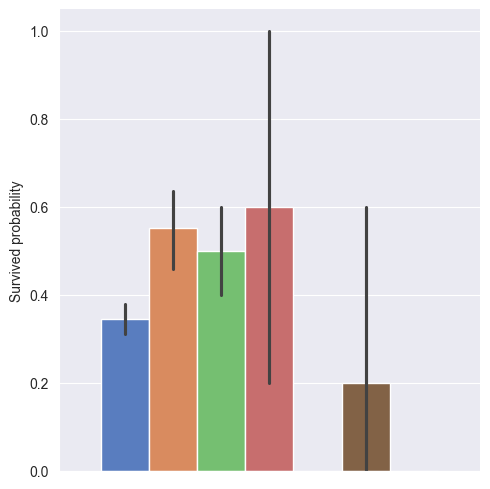

In [235]:
g = sns.catplot(hue="Parch", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

Age

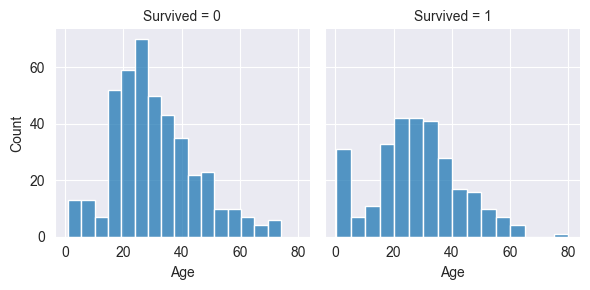

In [236]:
g = sns.FacetGrid(data=train_data, col="Survived")
g = g.map(sns.histplot  , "Age")

Fare

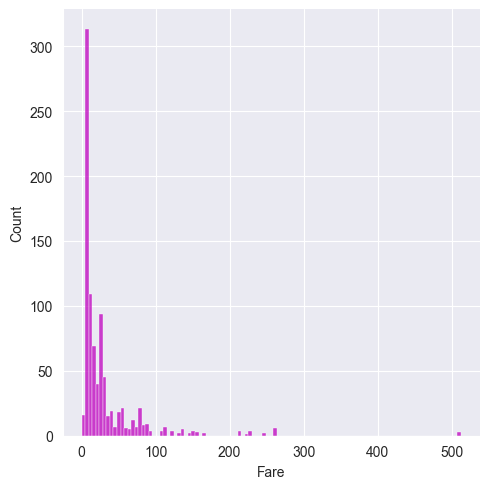

In [237]:
g = sns.displot(train_data["Fare"], color="m", label="Skewness: %.2f"%(train_data["Fare"].skew()))

In [238]:
# Apply log to Fare to reduce skewness distribution
train_data["Fare"] = train_data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

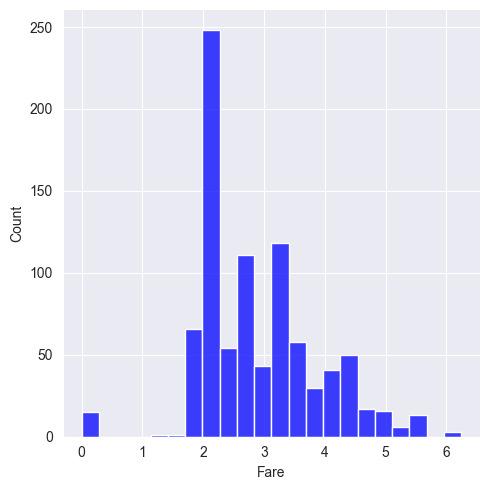

In [239]:
g = sns.displot(train_data["Fare"], color="b", label="Skewness: %.2f"%(train_data["Fare"].skew()))

Categorical variables

Sex

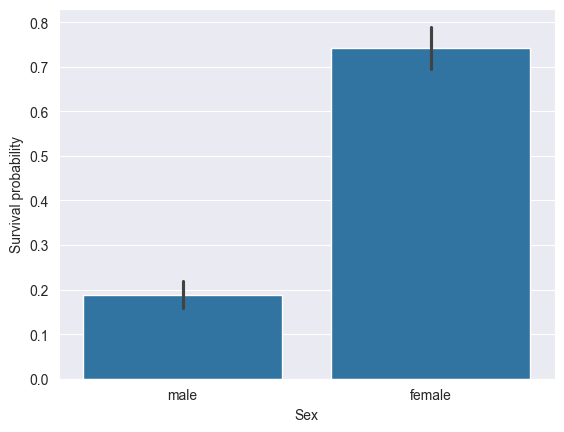

In [240]:
g = sns.barplot(x="Sex", y="Survived", data=train_data)
g = g.set_ylabel("Survival probability")

In [241]:
train_data[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Pclass

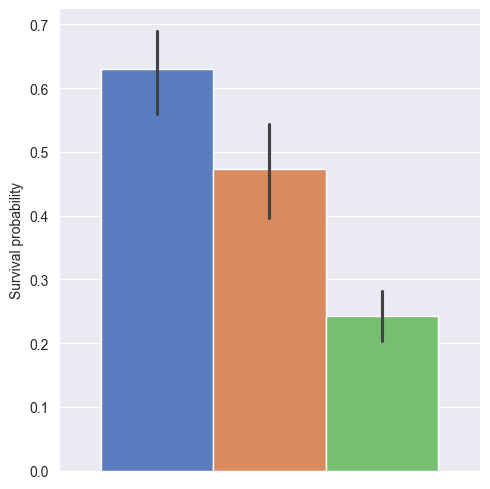

In [242]:
g = sns.catplot(hue="Pclass", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survival probability")

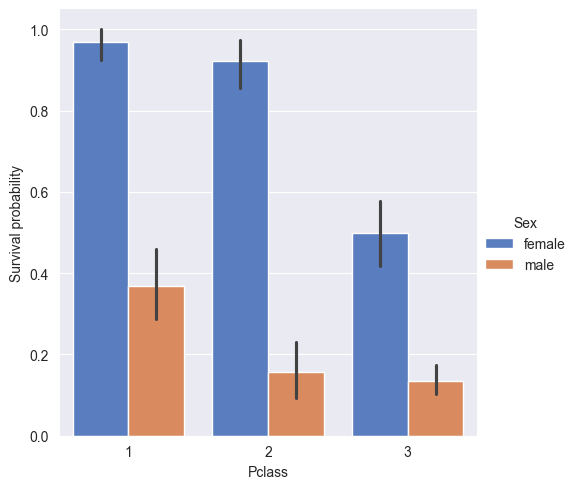

In [243]:
# Pclass vs Survived by Sex
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_data, kind="bar", palette="muted")
g = g.set_ylabels("Survival probability")

Embarked

In [244]:
train_data['Embarked'].isnull().sum()

2

In [245]:
train_data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [246]:
# Fill embarked nan values of dataset set with 'S', most frequent value
train_data['Embarked'] = train_data['Embarked'].fillna('S')

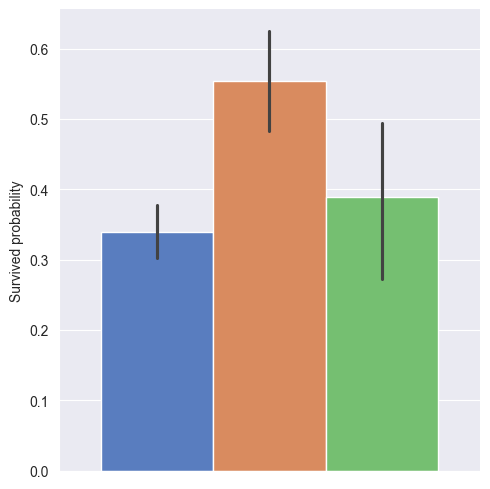

In [247]:
# Explore Embarked vs Survived
g = sns.catplot(hue="Embarked", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

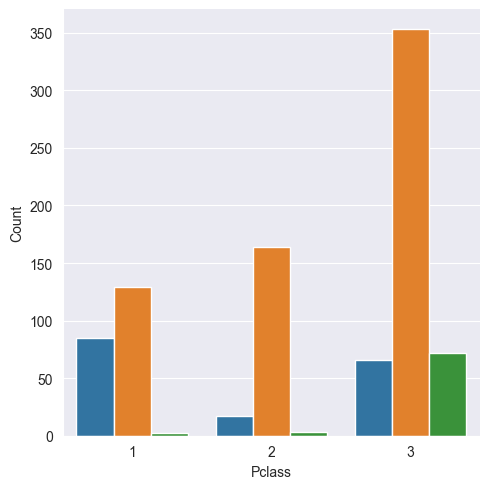

In [248]:
# Explore Embarked vs Pclass
g = sns.catplot(x="Pclass", hue="Embarked", data=train_data, kind="count", legend=False)
g = g.set_ylabels("Count")

Imports for train model

In [249]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split ,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Train model (new)

In [250]:
#x_train = train_data[features]
# y_train = train_data['Survived']
# 
# x_test = test_data[features]

features = ["Pclass", "SibSp", "Parch"]

# x_train = train_data.drop(columns=['Survived'])
x_train = train_data[features]
y_train = train_data['Survived']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [251]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers:
    print(classifier, "Done!")
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4, error_score="raise"))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis",'XGBClassifier']})
cv_res = cv_res.sort_values(by='CrossValMeans',ascending = False)

SVC(random_state=2) Done!
DecisionTreeClassifier(random_state=2) Done!
AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=2),
                   learning_rate=0.1, random_state=2) Done!
RandomForestClassifier(random_state=2) Done!
ExtraTreesClassifier(random_state=2) Done!
GradientBoostingClassifier(random_state=2) Done!
MLPClassifier(random_state=2) Done!
KNeighborsClassifier() Done!
LinearDiscriminantAnalysis() Done!
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
           

In [252]:
fig = make_subplots(rows=1, cols=1, 
                    specs=[[{"type": "bar"}]])

fig.add_trace(go.Bar(x=cv_res['CrossValMeans'], y=cv_res.Algorithm, marker=dict(color=['#334550','#334550','#334668','#334668','#496595','#496595','#6D83AA','#6D83AA','#91A2BF','#C8D0DF']),
                     name='Fare', orientation='h'), 
                     row=1, col=1)
# styling
fig.update_yaxes(showgrid=True, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=True, row=1, col=1)
fig.update_layout(height=500, bargap=0.1,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Cross Validation Scores",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Train model Gradient Boost (test)

In [253]:
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, random_state=100, max_features=5)

gbc.fit(x_train, y_train)

# Confusion matrix
print("Confusion matrix:\n", confusion_matrix(y_train, gbc.predict(x_train)))

# Accuracy of model
print("GBC accuracy is %2.2f" % accuracy_score(y_train, gbc.predict(x_train)))

# Classification report
pred = gbc.predict(x_train)
print(classification_report(y_train, pred))

Confusion matrix:
 [[364  80]
 [120 148]]
GBC accuracy is 0.72
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       444
           1       0.65      0.55      0.60       268

    accuracy                           0.72       712
   macro avg       0.70      0.69      0.69       712
weighted avg       0.71      0.72      0.71       712


Train model RandomForest (test)

In [254]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)

rf.fit(x_train, y_train)

print('Oob score:', rf.oob_score_)

Oob score: 0.7106741573033708


In [255]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 30, 50, 100, 200]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [256]:
grid_search.best_score_

0.7036516853932584

In [257]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=3, min_samples_leaf=20, n_estimators=10,
                       n_jobs=-1, random_state=0)

In [258]:
imp_df = pd.DataFrame({
    "Varname": x_train.columns,
    "Imp": rf_best.feature_importances_
})

imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,Pclass,0.658179
2,Parch,0.224249
1,SibSp,0.117572


Train model (submit)

In [259]:
y = train_data["Survived"]
features = ["Pclass", "SibSp", "Parch"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

rf = RandomForestClassifier(max_depth=3, min_samples_leaf=20, n_estimators=10, n_jobs=-1, random_state=0)
rf.fit(X, y)
predictions = rf.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


Save prediction to csv file

In [260]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


Check output

In [261]:
results = pd.read_csv('submission.csv')
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
